# Convolutional neural networks for CIFAR-10 data

* Cifar-10 data를 가지고 자신만의 **convolutional neural networks**를 만들어보자.
  * [참고: TensorFlow.org](https://www.tensorflow.org/get_started/mnist/pros)
  * [`tf.layers` API](https://www.tensorflow.org/api_docs/python/tf/layers)
  * [`tf.contrib.layers` API](https://www.tensorflow.org/api_docs/python/tf/contrib/layers)
* Data augmentation을 구현해보자
  * [`tf.data.Datatset.map()` API](https://www.tensorflow.org/guide/datasets#preprocessing_data_with_datasetmap)

## Import modules

In [1]:
"""A own CIFAR-10 classifier.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/lab4all/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.cifar10.load_data()

train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_labels = np.asarray(test_labels, dtype=np.int32)

In [3]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

N = 10000
train_data = train_data[:N]
train_labels = train_labels[:N]

In [5]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(10000, 32, 32, 3)
(10000,)
(10000, 32, 32, 3)
(10000,)


### Show the CIFAR-10 data

* `label = 0`: airplane
* `label = 1`: automobile
* `label = 2`: bird
* `label = 3`: cat
* `label = 4`: deer
* `label = 5`: dog
* `label = 6`: frog
* `label = 7`: horse
* `label = 8`: ship
* `label = 9`: truck

In [6]:
idx2label = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

label = deer


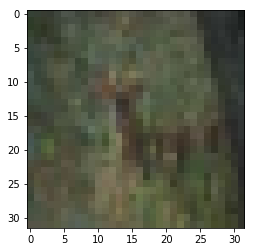

In [7]:
index = 10
print("label = {}".format(idx2label[train_labels[index]]))
plt.imshow(train_data[index])
#plt.gca().grid(False)
plt.show()

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [8]:
def _augmentation_function(image, label):
  """data augmentation function for training
  augmentation method is borrowed by inception code
  
  Args:
    image (3-rank Tensor): [32, 32, 3] for CIFAR-10 data
    label (0-rank Tensor): scalar value of corresponding image
    
  Returns:
    image_augmented (3-rank Tensor): [28, 28, 3] image transformed
    label (0-rank Tensor): scalar value of corresponding image
  """
  image_augmented = tf.image.resize_image_with_crop_or_pad(image, 28, 28)
  image_augmented.set_shape([28, 28, 3])
  image_augmented = tf.image.random_flip_left_right(image_augmented)
  image_augmented = tf.image.random_brightness(image_augmented, max_delta=32./255.)
  image_augmented = tf.image.random_saturation(image_augmented, lower=0.5, upper=1.5)
  image_augmented = tf.image.random_hue(image_augmented, max_delta=0.2)
  image_augmented = tf.image.random_contrast(image_augmented, lower=0.5, upper=1.5)
  image_augmented = tf.clip_by_value(image_augmented, 0.0, 1.0)
  return image_augmented, label

In [9]:
def _central_crop_for_test(image, label):
  """central crop function for test or eval
  
  Args:
    image (3-rank Tensor): [32, 32, 3] for CIFAR-10 data
    label (0-rank Tensor): scalar value of corresponding image
    
  Returns:
    image_augmented (3-rank Tensor): [28, 28, 3] image center cropped
    label (0-rank Tensor): scalar value of corresponding image
  """
  image_resized = tf.image.central_crop(image, central_fraction=0.85)
  image_resized.set_shape([28, 28, 3])
  return image_resized, label

In [10]:
tf.set_random_seed(219)
batch_size = 32
max_epochs = 3

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.map(_augmentation_function)
#train_dataset = train_dataset.map(_central_crop_for_test)
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count = max_epochs)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.map(_central_crop_for_test)
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28, 3), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 28, 28, 3), (?,)), types: (tf.float64, tf.int32)>


### Define Iterator

In [11]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle,
                                               train_dataset.output_types,
                                               train_dataset.output_shapes)
x, y = iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

## Create the model

In [12]:
def cnn_model_fn(x):
  """Model function for CNN.
  Args:
    x: input images
    
  Returns:
    logits: unnormalized score funtion
  """
  is_training = tf.placeholder(tf.bool)
  batch_norm_params = {'decay': 0.9,
                       'epsilon': 0.001,
                       'is_training': is_training,
                       'scope': 'batch_norm'}
  l2_decay = 0.0001
  
  # Input Layer
  # CIFAR-10 images are 32x32 pixels, and have RGB color channel
  # input image size: [28, 28, 3] for simplicity
  assert x.shape[1] == 28  and  x.shape[2] == 28  and  x.shape[3] == 3

  with slim.arg_scope([slim.conv2d],
                      kernel_size=[3, 3],
                      normalizer_fn=slim.batch_norm,
                      normalizer_params=batch_norm_params,
                      weights_regularizer=slim.l2_regularizer(l2_decay)):
    with slim.arg_scope([slim.max_pool2d],
                        kernel_size=[2, 2]):
      # Convolutional Layer #1
      # Input Tensor Shape: [batch_size, 28, 28, 3]
      # Output Tensor Shape: [batch_size, 28, 28, 32]
      conv1 = slim.conv2d(inputs=x, num_outputs=32, scope='conv1')

      # Pooling Layer #1
      # Input Tensor Shape: [batch_size, 28, 28, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 32]
      pool1 = slim.max_pool2d(inputs=conv1, scope='pool1')

      # Convolutional Layer #2
      # Input Tensor Shape: [batch_size, 14, 14, 32]
      # Output Tensor Shape: [batch_size, 14, 14, 64]
      conv2 = slim.conv2d(inputs=pool1, num_outputs=64, scope='conv2')

      # Pooling Layer #2
      # Second max pooling layer with a 2x2 filter and stride of 2
      # Input Tensor Shape: [batch_size, 14, 14, 64]
      # Output Tensor Shape: [batch_size, 7, 7, 64]
      pool2 = slim.max_pool2d(inputs=conv2, scope='pool2')
      
  with slim.arg_scope([slim.fully_connected],
                      normalizer_fn=slim.batch_norm,
                      normalizer_params=batch_norm_params,
                      weights_regularizer=slim.l2_regularizer(l2_decay)):

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = slim.flatten(pool2, scope='pool2_flat')

    # Fully connected Layer
    # Input Tensor Shape: [batch_size, 7 * 7 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    fc1 = slim.fully_connected(inputs=pool2_flat, num_outputs=1024, scope='fc1')

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = slim.dropout(inputs=fc1, keep_prob=0.6, is_training=is_training, scope='dropout')

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = slim.fully_connected(inputs=dropout, num_outputs=10, activation_fn=None, scope='logits')
  
  return logits, is_training

## Build the model

In [13]:
tf.set_random_seed(219)
logits, is_training = cnn_model_fn(x)

## Define cross entropy loss and regularization loss

In [14]:
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

l2_regualrization_loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

with tf.name_scope('total_loss'):
  total_loss = cross_entropy + l2_regualrization_loss

## Batch normalization update

In [15]:
# Batch normalization update
batchnorm_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

# Add dependency to compute batchnorm_updates.
with tf.control_dependencies(batchnorm_update_ops):
  train_step = tf.train.AdamOptimizer(1e-4).minimize(total_loss)

### Assign `tf.summary.FileWriter`

In [16]:
graph_location = 'graphs/07.cnn.cifar10.data.augmentation'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph())

Saving graph to: graphs/07.cnn.cifar10.data.augmentation


### `tf.summary`

In [17]:
with tf.name_scope('summaries'):
  tf.summary.scalar('loss/cross_entropy', cross_entropy)
  tf.summary.scalar('loss/l2_regualrization_loss', l2_regualrization_loss)
  tf.summary.scalar('loss/total_loss', total_loss)
  tf.summary.image('images', x)
  for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)
  # merge all summaries
  summary_op = tf.summary.merge_all()

## `tf.Session()` and train

In [18]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# train_iterator
train_iterator = train_dataset.make_one_shot_iterator()
train_handle = sess.run(train_iterator.string_handle())

# Train
step = 1
while True:
  try:
    start_time = time.time()
    _, loss = sess.run([train_step, cross_entropy],
                       feed_dict={handle: train_handle,
                                  is_training: True})
    if step % 10 == 0:
      clear_output(wait=True)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      epochs = batch_size * step / float(len(train_data))
      print("epochs: {:.2f}, step: {}, loss: {:g}, ({:.2f} examples/sec; {:.3f} sec/batch)".format(epochs, step, loss, examples_per_sec, duration))

    if step % 200 == 0:
      # summary
      summary_str = sess.run(summary_op, feed_dict={handle: train_handle, is_training: False})
      train_writer.add_summary(summary_str, global_step=step)

    step += 1

    #if step > 100:
    #  break

  except tf.errors.OutOfRangeError:
    print("End of dataset")  # ==> "End of dataset"
    break

train_writer.close()
print("training done!")

epochs: 2.98, step: 930, loss: 1.47578, (7881.72 examples/sec; 0.004 sec/batch)
End of dataset
training done!


## Test trained model

* test accuracy: 0.4594 for one epoch using partial training dataset N = 30000 (without regularization, data augmentation)
* test accuracy: 0.5714 for one epoch using partial training dataset N = 30000 (with regularization, w/o data augmentation)
* test accuracy: 0.5514 for 3 epochs using partial training dataset N = 10000 (with regularization, data augmentation)
* test accuracy: 0.5718 for 3 epochs using partial training dataset N = 10000 (with regularization, without data augmentation)

In [19]:
# test_iterator
test_iterator = test_dataset.make_one_shot_iterator()
test_handle = sess.run(test_iterator.string_handle())

In [20]:
accuracy, acc_op = tf.metrics.accuracy(labels=y, predictions=tf.argmax(logits, 1), name='accuracy')
sess.run(tf.local_variables_initializer())

sess.run(acc_op, feed_dict={handle: test_handle, is_training: False})
print("test accuracy:", sess.run(accuracy))

test accuracy: 0.5466


### Plot test set

In [21]:
np.random.seed(219)

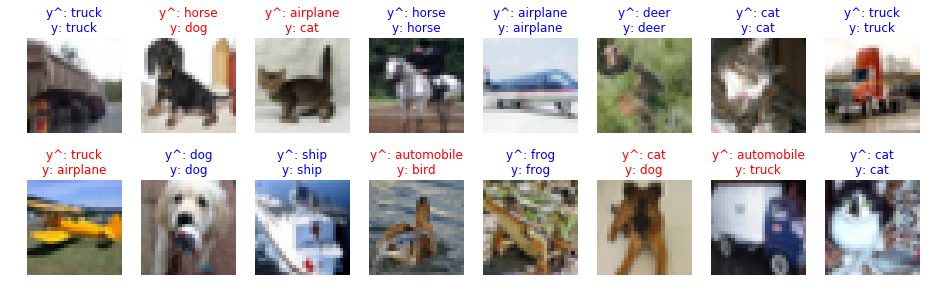

In [22]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)
batch_xs = test_data[batch_index, 2:-2, 2:-2, :]
batch_ys = test_labels[batch_index]
y_pred, x_aug_ = sess.run([logits, x],
                          feed_dict={x: batch_xs, is_training: False})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y^: {}\ny: {}".format(idx2label[np.argmax(py)], idx2label[batch_ys[i]]), color='blue')
  else:
    p.set_title("y^: {}\ny: {}".format(idx2label[np.argmax(py)], idx2label[batch_ys[i]]), color='red')
  p.imshow(px)
  p.axis('off')

## 직접 실습

* 여러가지 hyper-parameter들을 바꿔가면서 accuracy를 높혀보자